In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings(action='once')

# Pre-processing (to be done only once - data is transformed/processed and stored separately due to size)

In [ ]:
rawdata = pd.read_csv("C:/Users/abishek/Downloads/Pradeep_DS/ct_rr1.csv", sep=",")
rawdata.head(5)
rawdata.dtypes
rawdata['ts1']  = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in rawdata["ts"]]
rawdata['Date'] = [dt.datetime.date(d) for d in rawdata['ts1']]
rawdata['Time'] = [dt.datetime.time(d) for d in rawdata['ts1']]
rawdata['Hour'] = pd.to_datetime(rawdata['Time'], format='%H:%M:%S').dt.hour
# rawdata['custnum'] = pd.to_numeric(rawdata['number'], errors = 'ignore')
rawdata['Hour'] = pd.to_datetime(rawdata['Time'], format='%H:%M:%S').dt.hour
rawdata.head(5)
dataset = pd.DataFrame(rawdata.groupby(by=['Date','Hour']).size())
dataset = dataset.reset_index()
dataset.tail(5)
dataset['Rides'] = dataset.iloc[:, 2]
dataset = dataset[['Date','Hour','Rides']]
dataset.sort_values(by=['Date','Hour'],ascending = (True,True))
dataset.tail(25)
dataset.to_csv("C:/Users/abishek/Downloads/Pradeep_DS/dataset.csv", sep=",")

# Benchmark Solution (Simple Moving Average)

In [ ]:
dataset = pd.read_csv("C:/Users/abishek/Downloads/Pradeep_DS/dataset.csv", sep=",")

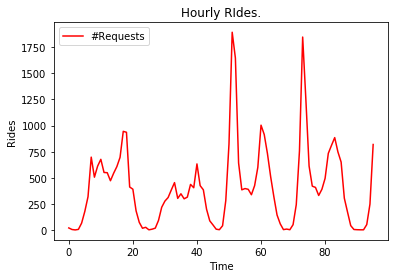

In [ ]:
# Visualising the data

plt.clf()
plt.plot(dataset.iloc[:96,3].values, color = 'red', label = '#Requests')
plt.title('Hourly RIdes.')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.legend()
plt.show()

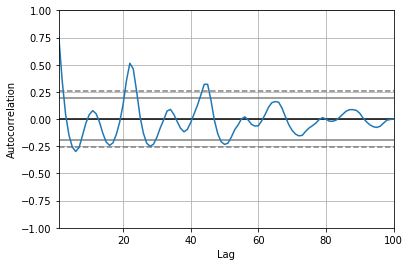

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(dataset['Rides'][0:100])

In [ ]:
# From the above plot, there seems to be good auto correlation for the first 40 odd lags. 
# So, a good starting point would be have 48 lags (2-days) in the model

In [ ]:
dataset.head(5)

,Unnamed: 0,Date,Hour,Rides
0,0,07-04-2018,1,20
1,1,07-04-2018,2,5
2,2,07-04-2018,3,1
3,3,07-04-2018,5,6
4,4,07-04-2018,6,66


In [ ]:
dataset1 = dataset.iloc[:, 3:4].values

In [ ]:
len(dataset1)

8546

In [ ]:
dataset1[0:5]

array([[20],
       [ 5],
       [ 1],
       [ 6],
       [66]], dtype=int64)

In [ ]:
dataset1.shape

(8546, 1)

In [ ]:
# Creating a simple moving average prediction with 48 lags
X = []
y = []
for i in range(48, len(dataset1)):
    X.append(dataset1[i-48:i, 0])
    y.append(dataset1[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
X.shape

(8498, 48, 1)

In [ ]:
# Predicting on entire data
y_pred = []
for i in range(y.shape[0]):
    y_pred.append(X[i].mean())

y_pred_np=np.array(y_pred)
y_np=np.array(y)
y_pred_np[y_pred_np < 0] = 0

In [ ]:
y_np.shape

(8498,)

In [ ]:
def rmse(act,pred):
    return ((act - pred)**2).mean() ** .5

In [ ]:
filnam = "C:/Users/abishek/Downloads/Pradeep_DS/MA_full_pred.csv"
df = pd.DataFrame(np.reshape(y_pred_np,(y_pred_np.shape[0],1)), columns=['Full_Pred'])
pd.concat([dataset,df], axis=1).to_csv(filnam)

rmse(y_pred_np, y_np)

1296.4684363534195

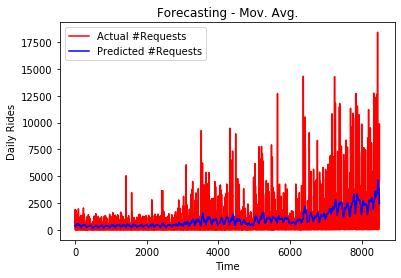

In [ ]:
# Visualising the results

plt.clf()
plt.plot(y_np, color = 'red', label = 'Actual #Requests')
plt.plot(y_pred_np, color = 'blue', label = 'Predicted #Requests')
plt.title('Forecasting - Mov. Avg.')
plt.xlabel('Time')
plt.ylabel('Daily Rides')
plt.legend()
plt.show()

# Solution 1 - Classic TS forecasting methods (ARIMA model)

In [ ]:
dataset = pd.read_csv("C:/Users/abishek/Downloads/Pradeep_DS/dataset.csv", sep=",")

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import log

H:\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
H:\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
# Augmented Dickey Fuller Test (ADF) for checking whether the series is stationary or not
ride_series = np.array(dataset[['Rides']])
print('ADF: %f' % adfuller(dataset['Rides'])[0])
print('p-value: %f' % adfuller(dataset['Rides'])[1])

ADF: -5.501200
p-value: 0.000002


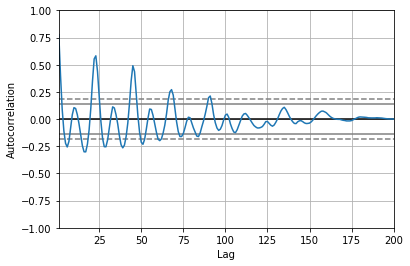

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(dataset['Rides'][0:200])
# Autocorrelation is whin threshold after 96 timesteps

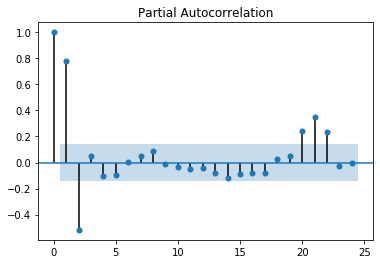

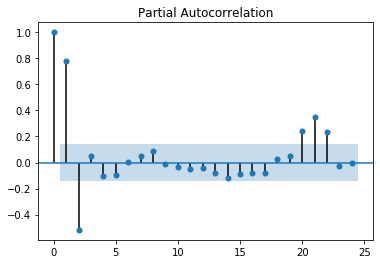

In [ ]:
plot_pacf(dataset['Rides'][0:200])
# The graphs cuts off after 3 timesteps

In [ ]:
# Making a Train/Test Split
data = dataset.iloc[:, 3].values
l = len(data)
data_train = dataset.iloc[:int(0.7*l), 3].values
data_test  = dataset.iloc[int(0.7*l):, 3].values

In [ ]:
len(data_train),len(data_test)

(5982, 2564)

In [ ]:
def rmse(act,pred):
    return ((act - pred)**2).mean() ** .5

In [ ]:
def eval_arima_mod(train, test, arima_order):
    model_fit = ARIMA(train, order=arima_order).fit(disp=0)
    pred = model_fit.forecast()[0]
    return rmse(test, pred)

In [ ]:
def arima_grid(train, test, p_values, d_values, q_values):
    samp1 = train.astype('float32')
    samp2 = test.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = eval_arima_mod(samp1, samp2, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print("Better ARIMA%s TEST-MSE=%.3f" % (order,mse))
                except:
                    continue
    print("Best ARIMA%s TEST-MSE=%.3f" % (best_cfg, best_score)) 

In [ ]:
# DO NOT RUN - TAKES A LOT OF TIME

print("ARIMA GRID SEARCH")
p_range = range(0, 121, 12)
d_range = [0,1]
q_range = range(0, 4, 1)
arima_grid(data_train, data_test, p_range, d_range, q_range)

ARIMA GRID SEARCH
Better ARIMA(0, 0, 0) TEST-MSE=2471.726


H:\python\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
H:\python\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
H:\python\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
H:\python\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Better ARIMA(12, 0, 3) TEST-MSE=2439.555
Better ARIMA(12, 1, 0) TEST-MSE=2419.237


In [ ]:
# Since the GRID takes a lot of time computationally, we use the AC, p-AC and ADF test to determine the AR, I and MA parts of ARIMA
best_cfg = (12,0,3)

# Running the ARIMA model on the entire dataset
model_fit = ARIMA(data_train, order=best_cfg).fit(disp=0)
pred = np.concatenate((model_fit.fittedvalues, model_fit.forecast(len(data_test))[0]), axis=0)
act = np.concatenate((data_train, data_test), axis=0)

H:\python\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
H:\python\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
H:\python\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
H:\python\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
# ARIMA returns a "flat" forecast because it doesn't take into account the heavy seasonality present in the data

pred_np = np.array(pred)
act_np = np.array(act)
rmse(act_np, pred_np)

1331.646836874654

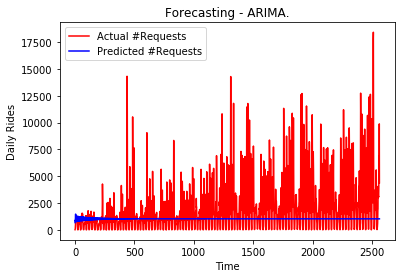

In [ ]:
# Visualising the results

plt.clf()
# plt.plot(act_np, color = 'red', label = 'Actual #Requests')
# plt.plot(pred_np, color = 'blue', label = 'Predicted #Requests')
plt.plot(data_test, color = 'red', label = 'Actual #Requests')
plt.plot(model_fit.forecast(len(data_test))[0], color = 'blue', label = 'Predicted #Requests')
plt.title('Forecasting - ARIMA.')
plt.xlabel('Time')
plt.ylabel('Daily Rides')
plt.legend()
plt.show()

In [ ]:
filnam = "C:/Users/abishek/Downloads/Pradeep_DS/ARIMA_full_pred.csv"
df = pd.DataFrame(pd.Series(pred_np, name='Full_Pred'))
df1 = pd.DataFrame(pd.Series(act_np, name='Actuals'))
pd.concat([df1,df], axis=1).to_csv(filnam)

# Solution 2 - Classic TS forecasting methods (Exponential Smoothening)

In [ ]:
dataset = pd.read_csv("C:/Users/abishek/Downloads/Pradeep_DS/dataset.csv", sep=",")

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, Holt

H:\python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
# Making a Train/Test Split
data = dataset.iloc[:, 3].values
l = len(data)
data_train = data[:int(0.7*l)]
data_test = data[int(0.7*l):]

In [ ]:
data_train[data_train == 0] = 2
data_test[data_test == 0] = 2

In [ ]:
def rmse(act,pred):
    return ((act - pred)**2).mean() ** .5

In [ ]:
# def eval_es_mod(train, test, params):
#     ser = [x for x in train.astype('float32')]
#     pred = []
#     for t in range(len(test)):
#         es_model = ExponentialSmoothing(ser, seasonal_periods=params[0], trend=params[1], seasonal=params[2], damped=params[3]).fit(useboxcox=params[4])
#         pred.append(es_model.forecast()[0])
#         ser.append(test[t])
    
#     return rmse(test, pred)

# def es_grid(train, test, ss_pd, tr_tp, ss_tp, dm_tp, bc_tp):
#     samp1 = train.astype('float32')
#     samp2 = test.astype('float32')
#     best_score, best_param = float("inf"), None
#     for p in ss_pd:
#         for q in tr_tp:
#             for r in ss_tp:
#                 for s in dm_tp:
#                     for t in bc_tp:
#                         params = (p, q, r, s, t)
#                         try:
#                             mse = eval_es_mod(samp1, samp2, params)
#                             if mse < best_score:
#                                 best_score, best_param = mse, params
#                                 print("Better ARIMA%s TEST-MSE=%.3f" % (params,mse))
#                         except:
#                             continue
#     print("Best parameters:")
#     print("Seasonal periods-",best_param[0])
#     print("Trend Type-",best_param[1])
#     print("Seasonal Type-",best_param[2])
#     print("Dampening-",best_param[3])
#     print("BoxCox Transformation-",best_param[4])
#     print("Best RMSE-",best_score)

# # DO NOT RUN - TAKES A LOT OF TIME

# print("ES GRID SEARCH")
# ss_pd_range = range(0, 121, 24)
# tr_tp_range = ['add','mul']
# ss_tp_range = ['add','mul']
# dm_tp_range = [True,False]
# bc_tp_range = [True,False]

# es_grid(data_train, data_test, ss_pd_range, tr_tp_range, ss_tp_range, dm_tp_range, bc_tp_range)

In [ ]:
def eval_es_mod(train, test, params):
    ser = [x for x in train.astype('float32')]
    pred = []
    es_model = ExponentialSmoothing(ser, seasonal_periods=params[0], trend=params[1], seasonal=params[2], damped=params[3]).fit(use_boxcox=params[4])

    return rmse(train, es_model.fittedvalues), rmse(test, es_model.forecast(len(test)))

In [ ]:
def es_grid(train, test, ss_pd, tr_tp, ss_tp, dm_tp, bc_tp):
    samp1 = train.astype('float32')
    samp2 = test.astype('float32')
    best_score, best_param = float("inf"), None
    for p in ss_pd:
        for q in tr_tp:
            for r in ss_tp:
                for s in dm_tp:
                    for t in bc_tp:
                        params = (p, q, r, s, t)
                        try:
                            mse = eval_es_mod(samp1, samp2, params)[1]
                            if mse < best_score:
                                best_score, best_param = mse, params
                                print("Better ARIMA%s TEST-MSE=%.3f" % (params,mse))
                        except:
                            continue
    
    print("Best parameters:")
    print("Seasonal periods-",best_param[0])
    print("Trend Type-",best_param[1])
    print("Seasonal Type-",best_param[2])
    print("Dampening-",best_param[3])
    print("BoxCox Transformation-",best_param[4])
    print("Best RMSE-",best_score)

In [ ]:
print("ES GRID SEARCH - 4")
ss_pd_range = [72, 120, 168, 240]
tr_tp_range = ['add']
ss_tp_range = ['add']
dm_tp_range = [True,False]
bc_tp_range = [True,False]

es_grid(data_train, data_test, ss_pd_range, tr_tp_range, ss_tp_range, dm_tp_range, bc_tp_range)

ES GRID SEARCH


H:\python\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Better ARIMA(72, 'add', 'add', True, True) TEST-MSE=2276.721


H:\python\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
H:\python\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
H:\python\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Best parameters:
Seasonal periods- 72
Trend Type- add
Seasonal Type- add
Dampening- True
BoxCox Transformation- True
Best RMSE- 2276.7213550468946


In [ ]:
# Running the best ES model & predicting on the entire dataset
es_model_f = ExponentialSmoothing(data_train, seasonal_periods=72, trend='add', seasonal='add', damped=False).fit(use_boxcox=True)

H:\python\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [ ]:
pred_np = np.concatenate((es_model_f.fittedvalues, es_model_f.forecast(len(data_test))), axis=0).astype('float32')
act_np = np.concatenate((data_train, data_test), axis=0).astype('float32')

In [ ]:
pred_np[np.isnan(pred_np)] = 0
x = es_model_f.fittedvalues
x[np.isnan(x)] = 0

In [ ]:
rmse(act_np,pred_np)

1631.9574136600502

In [ ]:
filnam = "C:/Users/abishek/Downloads/Pradeep_DS/ES_full_pred.csv"
df = pd.DataFrame(pd.Series(pred_np), columns=['Full_Pred'])
df1 = pd.DataFrame(pd.Series(act_np), columns=['Actuals'])
pd.concat([df1,df], axis=1).to_csv(filnam)

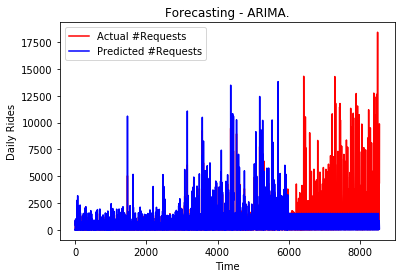

In [ ]:
# Visualising the results

plt.clf()
plt.plot(act_np, color = 'red', label = 'Actual #Requests')
plt.plot(pred_np, color = 'blue', label = 'Predicted #Requests')
plt.title('Forecasting - ARIMA.')
plt.xlabel('Time')
plt.ylabel('Daily Rides')
plt.legend()
plt.show()

# Solution 3 - Deep Learning

In [ ]:
dataset = pd.read_csv("C:/Users/abishek/Downloads/Pradeep_DS/dataset.csv", sep=",")

# Making a Train/Test Split
data_train = dataset.iloc[:6548, :]
data_test  = dataset.iloc[6548:, :]
data_train_np = data_train.iloc[:, 3:4].values
data_test_np = data_test.iloc[:, 3:4].values
    
# Scaling features

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(data_train_np)
test_set_scaled = sc.transform(data_test_np)
maxval = np.max(data_train_np)
minval = np.min(data_train_np)
#  * (maxval - minval) + minval
    
# Creating a data structure with 240 timesteps and 1 output
X_train = []
y_train = []
for i in range(240, 6548):
    X_train.append(training_set_scaled[i-240:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_test = []
y_test = []
for i in range(240, 1998):
    X_test.append(test_set_scaled[i-240:i, 0])
    y_test.append(test_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_train.shape

(6308, 240, 1)

In [ ]:
X_test.shape

(1758, 240, 1)

In [ ]:
y_train.shape

(6308,)

In [ ]:
y_test.shape

(1758,)

In [ ]:
def rmse(act,pred):
    return ((act - pred)**2).mean() ** .5

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout

In [ ]:
# Initialising
nn_reg = Sequential()

In [ ]:
# 1st LSTM layer with Dropout
nn_reg.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
nn_reg.add(Dropout(0.2))

In [ ]:
# 2nd LSTM layer with Dropout
nn_reg.add(LSTM(units = 50, return_sequences = True))
nn_reg.add(Dropout(0.2))

In [ ]:
# 3rd LSTM layer with Dropout
nn_reg.add(LSTM(units = 50, return_sequences = True))
nn_reg.add(Dropout(0.2))

In [ ]:
# 4th LSTM layer with Dropout
nn_reg.add(LSTM(units = 40))
nn_reg.add(Dropout(0.2))

In [ ]:
# Output Layer
nn_reg.add(Dense(units = 1))

In [ ]:
# Compiling & Fitting
nn_reg.compile(optimizer = 'adam', loss = 'mean_squared_error')
nn_reg.fit(X_train, y_train, epochs = 50, batch_size = None, validation_data=(X_test, y_test))

Train on 6308 samples, validate on 1758 samples
Epoch 1/50
6308/6308 [==============================] - 160s 25ms/step - loss: 0.0037 - val_loss: 0.0277
Epoch 2/50
6308/6308 [==============================] - 95s 15ms/step - loss: 0.0033 - val_loss: 0.0247
Epoch 3/50
6308/6308 [==============================] - 97s 15ms/step - loss: 0.0031 - val_loss: 0.0230
Epoch 4/50
6308/6308 [==============================] - 98s 16ms/step - loss: 0.0025 - val_loss: 0.0188
Epoch 5/50
6308/6308 [==============================] - 99s 16ms/step - loss: 0.0025 - val_loss: 0.0209
Epoch 6/50
6308/6308 [==============================] - 100s 16ms/step - loss: 0.0023 - val_loss: 0.0214
Epoch 7/50
6308/6308 [==============================] - 99s 16ms/step - loss: 0.0023 - val_loss: 0.0177
Epoch 8/50
6308/6308 [==============================] - 100s 16ms/step - loss: 0.0022 - val_loss: 0.0245
Epoch 9/50
6308/6308 [==============================] - 100s 16ms/step - loss: 0.0022 - val_loss: 0.0186
Epoch 10/50


In [ ]:
# Predictions & Visualisation of results

In [ ]:
# Visualising the results on train data

y_train_pred_np = nn_reg.predict(X_train)
y_train_pred_np[y_train_pred_np < 0] = 0

In [ ]:
y_train_np = np.array(y_train)
y_train_np1 = np.reshape(y_train_np, (y_train_np.shape[0], 1))
y_train_pred_np1 = np.reshape(y_train_pred_np, (y_train_pred_np.shape[0], 1))

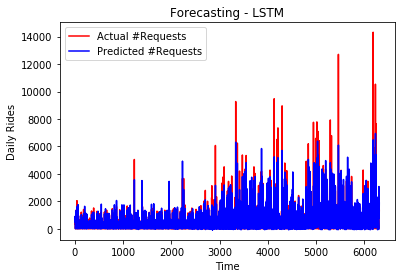

In [ ]:
plt.clf()
plt.plot(sc.inverse_transform(y_train_np1), color = 'red', label = 'Actual #Requests')
plt.plot(sc.inverse_transform(y_train_pred_np1), color = 'blue', label = 'Predicted #Requests')
plt.title('Forecasting - LSTM')
plt.xlabel('Time')
plt.ylabel('Daily Rides')
plt.legend()
plt.show()

In [ ]:
rmse(sc.inverse_transform(y_train_pred_np1), sc.inverse_transform(y_train_np1))

413.084582674384

In [ ]:
# Visualising the results on test data

y_test_pred_np = nn_reg.predict(X_test)
y_test_pred_np[y_test_pred_np < 0] = 0

In [ ]:
y_test_np = np.array(y_test)
y_test_np1 = np.reshape(y_test_np, (y_test_np.shape[0], 1))
y_test_pred_np1 = np.reshape(y_test_pred_np, (y_test_pred_np.shape[0], 1))

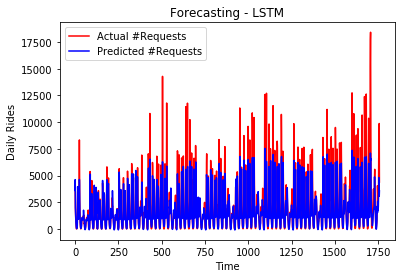

In [ ]:
plt.clf()
plt.plot(sc.inverse_transform(y_test_np1), color = 'red', label = 'Actual #Requests')
plt.plot(sc.inverse_transform(y_test_pred_np1), color = 'blue', label = 'Predicted #Requests')
plt.title('Forecasting - LSTM')
plt.xlabel('Time')
plt.ylabel('Daily Rides')
plt.legend()
plt.show()

In [ ]:
rmse(sc.inverse_transform(y_test_pred_np1), sc.inverse_transform(y_test_np1))

1235.0652694501903

In [ ]:
# Saving the entire prediction 

In [ ]:
data_pred = dataset.iloc[:, 3:4].values

# Scaling features

pred_set_scaled = sc.transform(data_pred)
maxval = np.max(pred_set_scaled)
minval = np.min(pred_set_scaled)
#  * (maxval - minval) + minval
    
# Creating a data structure with 240 timesteps and 1 output
X = []
y = []
for i in range(240, len(pred_set_scaled)):
    X.append(pred_set_scaled[i-240:i, 0])
    y.append(pred_set_scaled[i, 0])
    
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
# Predicting on entire data

y_pred_np = nn_reg.predict(X)
y_pred_np[y_pred_np < 0] = 0
y_np = np.array(y)
y_np1 = np.reshape(y_np, (y_np.shape[0], 1))
y_pred_np1 = np.reshape(y_pred_np, (y_pred_np.shape[0], 1))

In [ ]:
pd.DataFrame(sc.inverse_transform(y_pred_np1), columns=['Full_Pred']).to_csv("C:/Users/abishek/Downloads/Pradeep_DS/LSTM_test_pred.csv")

In [ ]:
rmse(sc.inverse_transform(y_pred_np1), sc.inverse_transform(y_np1))

677.0516901979603

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

nn_reg_json = nn_reg.to_json()

with open("C:/Users/abishek/Downloads/Pradeep_DS/ovl_lstm_model.json", "w") as json_file:
    json_file.write(nn_reg_json)

nn_reg.save("C:/Users/abishek/Downloads/Pradeep_DS/ovl_lstm_model.h5")
nn_reg.save_weights("C:/Users/abishek/Downloads/Pradeep_DS/ovl_lstm_weights.h5")

# Solution 3 - Granular Forecasting

In [ ]:
import pickle

In [ ]:
# Since no demographic data is given to segment the data and do granular forecasting, let's create our own demographies by a simple k-means
# Creating Segments/Clusters based on pick up latitude & longitude (using k-means) as proxy for location
    
rawdata = pd.read_csv("C:/Users/abishek/Downloads/Pradeep_DS/rawdata.csv", sep=",")

H:\python\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
rawdata.head()

,Unnamed: 0,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,ts1,Date,Time
0,0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280,2018-04-07 07:07:17,2018-04-07,07:07:17
1,1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770,2018-04-07 07:32:27,2018-04-07,07:32:27
2,2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950,2018-04-07 07:36:44,2018-04-07,07:36:44
3,3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375,2018-04-07 07:38:00,2018-04-07,07:38:00
4,4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950,2018-04-07 07:39:29,2018-04-07,07:39:29


In [ ]:
X = rawdata.iloc[:, [3,4]].values
X[0:5]

array([[12.3136215, 76.658195 ],
       [12.943947 , 77.560745 ],
       [12.899603 , 77.5873   ],
       [12.918229 , 77.607544 ],
       [12.89949  , 77.58727  ]])

In [ ]:
wcss = []

# Iterating over many values of clusters to find the optimal number
for i in range(5, 16):
    mbkmeans = MiniBatchKMeans(batch_size=256, n_clusters = i, init = 'k-means++', random_state = 42)
    mbkmeans.fit(X)
    wcss.append(mbkmeans.inertia_)

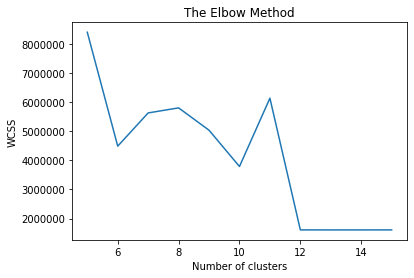

In [ ]:
plt.plot(range(5, 16), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# According to the elbow curve, 12 clusters does the job

mbkmeans = MiniBatchKMeans(batch_size=256, n_clusters = 12, init = 'k-means++', random_state = 42)

tf_data = rawdata
tf_data['Cluster'] = pd.Series(mbkmeans.fit_predict(X))

In [ ]:
pkl_file = "C:/Users/abishek/Downloads/Pradeep_DS/KMeans_Model_Pickle.pkl"
with open(pkl_file, 'wb') as file:
    pickle.dump(mbkmeans, file)

In [ ]:
# code to load the model

pkl_file = "C:/Users/abishek/Downloads/Pradeep_DS/KMeans_Model_Pickle.pkl"

with open(pkl_file, 'rb') as file:
        pickled_model = pickle.load(file)

pickled_model

MiniBatchKMeans(batch_size=256, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=12, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [ ]:
tf_data.tail(5)

,Unnamed: 0,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,ts1,Date,Time,Cluster
8381551,8381551,2019-04-07 23:55:24,50410,12.907856,77.55787,12.954270,77.530785,2019-04-07 23:55:24,2019-04-07,23:55:24,8
8381552,8381552,2019-04-07 23:58:15,12580,12.981010,77.69445,12.969070,77.704280,2019-04-07 23:58:15,2019-04-07,23:58:15,10
8381553,8381553,2019-04-07 22:11:20,72339,12.924252,77.65052,12.905820,77.630570,2019-04-07 22:11:20,2019-04-07,22:11:20,6
8381554,8381554,2019-04-07 22:12:30,72339,12.924252,77.65052,12.905820,77.630570,2019-04-07 22:12:30,2019-04-07,22:12:30,6
8381555,8381555,2019-04-07 15:00:55,28043,12.901222,77.59489,12.908599,77.649330,2019-04-07 15:00:55,2019-04-07,15:00:55,11


In [ ]:
tf_data['Hour'] = pd.to_datetime(tf_data['Time'], format='%H:%M:%S').dt.hour
tf_dataset = pd.DataFrame(tf_data.groupby(by=['Date','Hour','Cluster']).size())

In [ ]:
tf_dataset.tail(5)

0
Date       Hour Cluster      
2019-04-07 23   7         408
                8         865
                9        1379
                10        282
                11        311

In [ ]:
tf_dataset = tf_dataset.reset_index()
tf_dataset['Rides'] = tf_dataset.iloc[:, 3]

In [ ]:
tf_dataset.head(10)

,Date,Hour,Cluster,0,Rides
0,2018-04-07,1,3,9,9
1,2018-04-07,1,7,2,2
2,2018-04-07,1,9,4,4
3,2018-04-07,1,10,5,5
4,2018-04-07,2,3,1,1
5,2018-04-07,2,8,1,1
6,2018-04-07,2,9,3,3
7,2018-04-07,3,9,1,1
8,2018-04-07,5,4,1,1
9,2018-04-07,5,8,1,1


In [ ]:
tf_dataset = tf_dataset[['Date','Hour','Cluster','Rides']]
tf_dataset.sort_values(by=['Date','Hour','Cluster'],ascending = (True,True,True))
tf_dataset.tail(25)

,Date,Hour,Cluster,Rides
80590,2019-04-07,21,8,982
80591,2019-04-07,21,9,1175
80592,2019-04-07,21,10,649
80593,2019-04-07,21,11,411
80594,2019-04-07,22,0,604
80595,2019-04-07,22,1,25
80596,2019-04-07,22,3,987
80597,2019-04-07,22,4,88
80598,2019-04-07,22,5,2
80599,2019-04-07,22,6,549


In [ ]:
tf_dataset.to_csv("C:/Users/abishek/Downloads/Pradeep_DS/tf_dataset.csv", sep=",")

In [ ]:
def rmse(act,pred):
    return ((act - pred)**2).mean() ** .5

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import load_model

Using TensorFlow backend.
H:\python\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
H:\python\lib\site-packages\tensorflow\python\keras\backend.py:5275: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\abishek\\.keras\\keras.json' mode='r' encoding='cp1252'>
  _config = json.load(open(_config_path))
H:\python\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])


In [ ]:
tf_dataset = pd.read_csv("C:/Users/abishek/Downloads/Pradeep_DS/tf_dataset.csv", sep=",")

In [ ]:
tf_dataset.head(10)

,Unnamed: 0,Date,Hour,Cluster,Rides
0,0,2018-04-07,1,3,9
1,1,2018-04-07,1,7,2
2,2,2018-04-07,1,9,4
3,3,2018-04-07,1,10,5
4,4,2018-04-07,2,3,1
5,5,2018-04-07,2,8,1
6,6,2018-04-07,2,9,3
7,7,2018-04-07,3,9,1
8,8,2018-04-07,5,4,1
9,9,2018-04-07,5,8,1


In [ ]:
tf_dataset.groupby(by=['Cluster']).size()

Cluster
0     7402
1     6188
2     4817
3     7879
4     7199
5     1007
6     7455
7     7579
8     7934
9     7958
10    7392
11    7805
dtype: int64

In [ ]:
def clust_forecast(clusno, numlag, epch):
    dataset_tf1 = tf_dataset[tf_dataset['Cluster'] == clusno ]
    l = len(dataset_tf1)
    
    # Making a Train/Test Split
    data_train_np = dataset_tf1.iloc[:int(0.7*l), 4:5].values
    data_test_np  = dataset_tf1.iloc[int(0.7*l)-numlag:, 4:5].values
    
    # Scaling features
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(data_train_np)
    test_set_scaled = sc.transform(data_test_np)
    l_train = len(training_set_scaled)
    l_test = len(test_set_scaled)
    
    # Creating a data structure with numlag timesteps and 1 output
    X_train = []
    y_train = []
    for i in range(numlag, l_train):
        X_train.append(training_set_scaled[i-numlag:i, 0])
        y_train.append(training_set_scaled[i, 0])
    
    X_test = []
    y_test = []
    for i in range(numlag, l_test):
        X_test.append(test_set_scaled[i-numlag:i, 0])
        y_test.append(test_set_scaled[i, 0])
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Initialising
    clus_nn_reg = Sequential()
    # 1st LSTM layer with Dropout
    clus_nn_reg.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    clus_nn_reg.add(Dropout(0.2))
    # 2nd LSTM layer with Dropout
    clus_nn_reg.add(LSTM(units = 50, return_sequences = True))
    clus_nn_reg.add(Dropout(0.2))
    # 3rd LSTM layer with Dropout
    clus_nn_reg.add(LSTM(units = 50, return_sequences = True))
    clus_nn_reg.add(Dropout(0.2))
    # 4th LSTM layer with Dropout
    clus_nn_reg.add(LSTM(units = 50))
    clus_nn_reg.add(Dropout(0.2))
    # Output Layer
    clus_nn_reg.add(Dense(units = 1))
    # Compiling & Fitting
    clus_nn_reg.compile(optimizer = 'adam', loss = 'mean_squared_error')
    clus_nn_reg.fit(X_train, y_train, epochs = epch, validation_data=(X_test,y_test))
        
    # Predictions & Reconcilation of results on training & test data
    
    y_train1 = np.reshape(y_train, (y_train.shape[0], 1))
    y_test1 = np.reshape(y_test, (y_test.shape[0], 1))
    
    y_train_pred_np = clus_nn_reg.predict(X_train)
    rmse(sc.inverse_transform(y_train_pred_np), sc.inverse_transform(y_train1))

    y_test_pred_np = clus_nn_reg.predict(X_test)
    rmse(sc.inverse_transform(y_test_pred_np), sc.inverse_transform(y_test1))
    
    # Saving the model and weights to files
    
    modpath = ("C:/Users/abishek/Downloads/Pradeep_DS/cluster_"+str(clusno)+"_lstm_model.json").strip()
    modpath1 = ("C:/Users/abishek/Downloads/Pradeep_DS/cluster_"+str(clusno)+"_lstm_model.h5").strip()
    wghtpath = ("C:/Users/abishek/Downloads/Pradeep_DS/cluster_"+str(clusno)+"_lstm_weights.h5").strip()
    
    nn_reg_json = clus_nn_reg.to_json()
    with open(modpath, "w") as json_file:
        json_file.write(nn_reg_json)

    clus_nn_reg.save(modpath)
    clus_nn_reg.save_weights(wghtpath)
    
    # Taking the entire time series data, predicting and storing related metrics and predicted values
    
    pred_set_scaled = np.concatenate((training_set_scaled, test_set_scaled), axis=0)
    X = []
    y = []
    l_pred = len(pred_set_scaled)
    for i in range(numlag, l_pred):
        X.append(pred_set_scaled[i-numlag:i, 0])
        y.append(pred_set_scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Predicting on entire data
    y_pred_np = clus_nn_reg.predict(X)
    y_pred_np[y_pred_np < 0] = 0
    y_np = np.array(y)
    y_np1 = np.reshape(y_np, (y_np.shape[0], 1))
    y_pred_np1 = np.reshape(y_pred_np, (y_pred_np.shape[0], 1))

    filnam = "C:/Users/abishek/Downloads/Pradeep_DS/Cluster_"+str(clusno)+"_LSTM_full_pred.csv"
    df = pd.DataFrame(np.reshape(sc.inverse_transform(y_pred_np1),len(y_pred_np1)), columns=['Full_Pred'])
    pd.concat([dataset_tf1,df], axis=1).to_csv(filnam)
    
    rms = rmse(sc.inverse_transform(y_pred_np1), sc.inverse_transform(y_np1))
    
    from keras.backend import clear_session
    clear_session()
    
    return rms

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
errors=[]

In [ ]:
for i in range(6,12):
    if i == 5:
        rms=clust_forecast(
            i, 120, 20)
        errors.append([i,rms])
    else:
        rms=clust_forecast(i, 240, 20)
        errors.append([i,rms])

errors

Train on 4978 samples, validate on 2237 samples
Epoch 1/20
4978/4978 [==============================] - 84s 17ms/step - loss: 0.0035 - val_loss: 0.0286
Epoch 2/20
4978/4978 [==============================] - 83s 17ms/step - loss: 0.0034 - val_loss: 0.0272
Epoch 3/20
4978/4978 [==============================] - 83s 17ms/step - loss: 0.0034 - val_loss: 0.0278
Epoch 4/20
4978/4978 [==============================] - 82s 16ms/step - loss: 0.0034 - val_loss: 0.0288
Epoch 5/20
4978/4978 [==============================] - 83s 17ms/step - loss: 0.0034 - val_loss: 0.0282
Epoch 6/20
4978/4978 [==============================] - 83s 17ms/step - loss: 0.0034 - val_loss: 0.0314
Epoch 7/20
4978/4978 [==============================] - 82s 16ms/step - loss: 0.0034 - val_loss: 0.0283
Epoch 8/20
4978/4978 [==============================] - 82s 16ms/step - loss: 0.0033 - val_loss: 0.0321
Epoch 9/20
4978/4978 [==============================] - 82s 16ms/step - loss: 0.0034 - val_loss: 0.0315
Epoch 10/20
4978

[[6, 131.49334321180424],
 [7, 108.83462907663296],
 [8, 151.0042615590272],
 [9, 185.99555362729407],
 [10, 146.34109099721687],
 [11, 147.03934048385528]]